# Анализ эксперимента

В нашем AB-эксперименте метрики ARPU и ARPPU прокрасились разнонаправленно (обязательно убедитесь в этом самостоятельно). Почему так произошло? И главное: в чём конкретная продуктовая проблема? Вам необходимо выдвинуть различные продуктовые гипотезы и проверить их с помощью AB-тестирования.

Вам доступен датасет _exp_arppu_problem.tsv_, содержащий данные в следующем формате:
* userid — идентификатор пользователя;
* timestamp — дата и время события в формате Unix Timestamp;
* action — действие, совершенное пользователем, может принимать одно из значений:
* value — стоимость добавляемого товара (для события cart), либо сумма заказа (для событий checkout и confirmation);
* testids — идентификаторы тестовых выборок, в которых находится пользователь.

Проведите развёрнутый анализ AB-эксперимента с тестовой и контрольной выборками _34265_ и _34266_, соответственно, и объясните противоречивый сигнал метрик ARPU и ARPPU. Статистически обоснуйте сделанные вами выводы на уровне значимости _α = 0.05_ и наглядно продемонстрируйте ход ваших рассуждений с помощью диагностического вывода на экран всех существенных этапов проведенного вами анализа.

## Загрузка и подготовка данных

In [1]:
from IPython.display import display
import matplotlib.pyplot as plt

from scipy.stats import permutation_test
import pandas as pd
import numpy as np

alpha = 0.05

exp_testid = 34265
control_testid = 34266

seed = 123

In [2]:
def statistic_arpu(a, b):
    return np.mean(a) - np.mean(b)


def statistic_arppu(a, b):
    return np.mean(a[a != 0]) - np.mean(b[b != 0])


def revenues_by_user(df: pd.DataFrame) -> pd.DataFrame:
    return df.groupby(["userid"]).agg(
        # userid=pd.NamedAgg(column="userid", aggfunc="first"),
        val=pd.NamedAgg(column="value", aggfunc="sum"),
    ).reset_index(drop=True)


def prepare_frames(fname: str):
    df_ = pd.read_csv(fname, delimiter="\t")
    
    df_["userid"] = df_["userid"].apply(lambda x: int(x.split("_")[-1]))
    df_["value"] *= df_["action"].apply(lambda x: 1 if x == "confirmation" else 0)
    # df_.drop(["timestamp", "action"], axis=1, inplace=True)
    
    df_exp_ = df_[df_["testids"].str.contains(str(exp_testid))].drop(["testids"], axis=1)
    df_control_ = df_[df_["testids"].str.contains(str(control_testid))].drop(["testids"], axis=1)
    
    return df_, df_exp_, df_control_

In [3]:
df, df_exp, df_control = prepare_frames("exp_arppu_problem.tsv")

df.info()

df_exp.info()
df_control.info()

display(df_exp.head())
display(df_control.head())

print(set(df_exp["userid"]) & set(df_control["userid"]))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 488766 entries, 0 to 488765
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userid     488766 non-null  int64  
 1   timestamp  488766 non-null  int64  
 2   action     488766 non-null  object 
 3   value      488766 non-null  float64
 4   testids    488766 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 18.6+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 72425 entries, 0 to 488762
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   userid     72425 non-null  int64  
 1   timestamp  72425 non-null  int64  
 2   action     72425 non-null  object 
 3   value      72425 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 2.8+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 80368 entries, 40 to 488671
Data columns (total 4 columns):
 #   Column     Non-Null Coun

,userid,timestamp,action,value
0,10000,1659338271,mainpage,0.0
1,10000,1659424675,category,0.0
2,10000,1659424692,cart,0.0
3,10000,1659424704,checkout,0.0
4,10000,1659424709,confirmation,14400.0


,userid,timestamp,action,value
40,10001,1659559451,product,0.0
41,10001,1659732271,product,0.0
42,10001,1659732284,mainpage,0.0
43,10001,1659732285,product,0.0
44,10001,1659732311,search,0.0


set()


In [4]:
df_exp_rev = revenues_by_user(df_exp)
df_control_rev = revenues_by_user(df_control)
# df_exp_rev.info()
# df_control_rev.info()

## Исследование метрик

ARPU

0.0016 red
True -4781.22


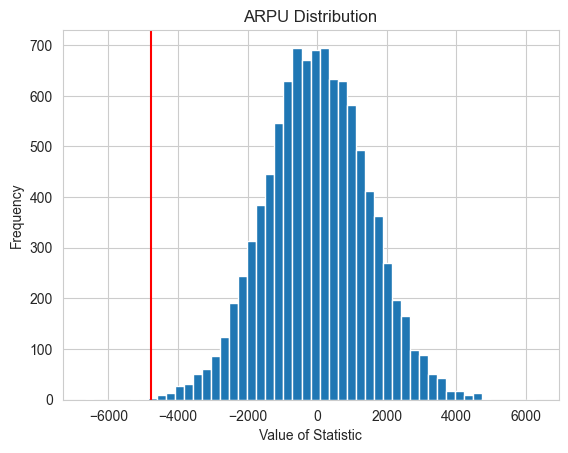

In [6]:
np.random.seed(seed)
res_1_arpu = permutation_test((df_exp_rev["val"], df_control_rev["val"]), statistic_arpu, permutation_type='independent')

c = "red" if res_1_arpu.statistic < 0 else "green"
print(round(res_1_arpu.pvalue, 5), c if res_1_arpu.pvalue < alpha else "gray")

print(res_1_arpu.pvalue < alpha, round(statistic_arpu(df_exp_rev["val"], df_control_rev["val"]), 2))

plt.hist(res_1_arpu.null_distribution, bins=50)
plt.axvline(res_1_arpu.statistic, color='r')
plt.xlabel("Value of Statistic")
plt.ylabel("Frequency")
plt.title("ARPU Distribution")
# plt.grid()
plt.show()

ARPPU

0.0396 green
True 4264.85


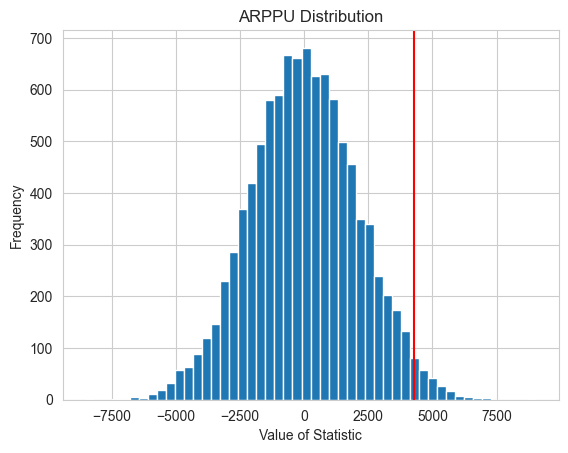

In [7]:
np.random.seed(seed)
res_2_arppu = permutation_test((df_exp_rev["val"], df_control_rev["val"]), statistic_arppu, permutation_type='independent')

c = "red" if res_2_arppu.statistic < 0 else "green"
print(round(res_2_arppu.pvalue, 5), c if res_2_arppu.pvalue < alpha else "gray")

print(res_2_arppu.pvalue < alpha, round(statistic_arppu(df_exp_rev["val"], df_control_rev["val"]), 2))

plt.hist(res_2_arppu.null_distribution, bins=50)
plt.axvline(res_2_arppu.statistic, color='r')
plt.xlabel("Value of Statistic")
plt.ylabel("Frequency")
plt.title("ARPPU Distribution")
# plt.grid()
plt.show()

## Продуктовая проблема (аномалия)

Метрика ARPU показала значительный спад, а метрика ARPPU напротив довольно точно показала рост в эксперементальной группе. 

Продуктовая проблема в том, что противоречие двух метрик не даёт ответа на A/B эксперемент (был ли его результат положительным или жу отрицательным для бизнеса).

## Выявление причин аномалии

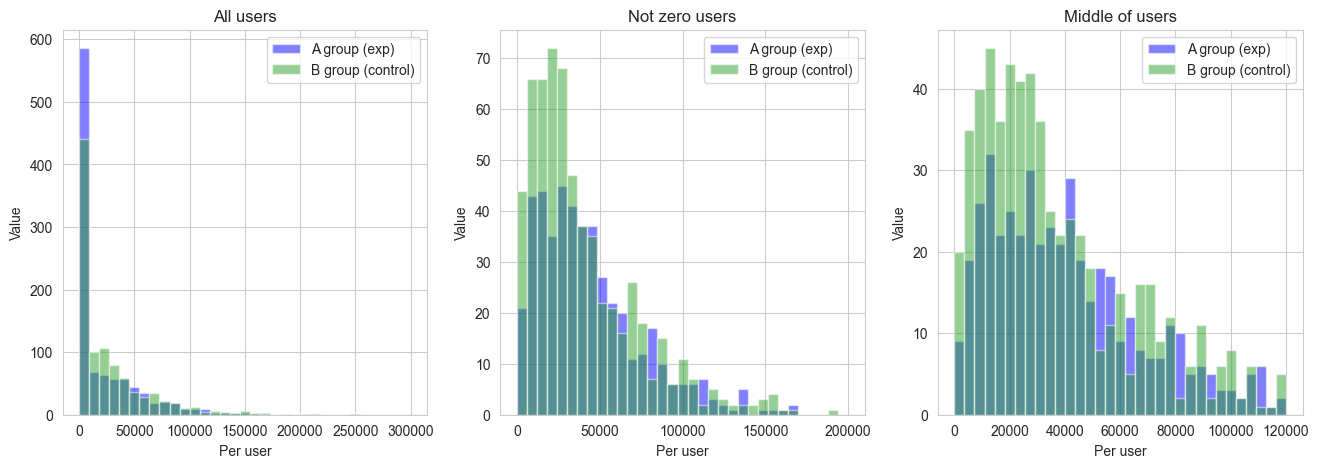

In [8]:
fig = plt.figure(figsize=(16, 5))
axes = [0]*3

plt_vals = [
    ('All users', (0, 300_000)),
    ('Not zero users', (1, 200_000)),
    ('Middle of users', (1, 120_000)),
]
plt_bins, plt_alpha = 33, 0.5

for i in range(3):
    axes[i] = fig.add_subplot(1, 3, i+1)
    plt.hist(df_exp_rev.val, bins=plt_bins, color='b', alpha=plt_alpha, range=plt_vals[i][1], label='A group (exp)')
    plt.hist(df_control_rev.val, bins=plt_bins, color='C2', alpha=plt_alpha, range=plt_vals[i][1], label='B group (control)')
    plt.title(plt_vals[i][0])
    plt.xlabel("Per user")
    plt.ylabel("Value")
    plt.legend()

plt.show()

In [9]:
# df_exp_rev.info()
# df_control_rev.info()
print("A (exp) \tB (control)\n")
print("Len users:", len(df_exp_rev), len(df_control_rev), sep="\t")
print("Len not zero users:", len(df_exp_rev[df_exp_rev.val != 0]), len(df_control_rev[df_control_rev.val != 0]), sep="\t")
print("All sum:", sum(df_exp_rev.val), sum(df_control_rev.val), sep="\t")
print("ARPU per user:", round(sum(df_exp_rev.val) / len(df_exp_rev)),
                       round(sum(df_control_rev.val) / len(df_control_rev)), sep="\t")
print("ARPPU per user:", round(sum(df_exp_rev.val) / len(df_exp_rev[df_exp_rev.val != 0])),
                        round(sum(df_control_rev.val) / len(df_control_rev[df_control_rev.val != 0])), sep="\t")

A (exp) 	B (control)

Len users:	1012	976
Len not zero users:	465	612
All sum:	20689561.0	24620044.0
ARPU per user:	20444	25225
ARPPU per user:	44494	40229


## Выводы

A & B группы довольно сильно отличаются.

В группе **A (exp)** (эксперементальной) меньше доля пользователей, который совершали хотя бы 1 покупку. Но при этом те пользователи, которые совершали хотя бы 1 покупку, в сумме купили больше. 

В группе **B (control)** (контрольной) соответственно больше активных пользователей, но активный пользователь в сумме покупает меньше.

Мне субъективно кажется, что контрольная группа B лучше, т.к. вся она в общем совершала покупки на большую сумму.

Однако, решение остаётся за ЛПР, т.к. нужно выбрать из двух разнонаправленных метрик, ту которая лучше скажется на бизнесе. 